# [NLP] 멋진 단어사전 만들기
## Step 1. SentencePiece 설치하기
## Step 2. SentencePiece 모델 학습
## Step 3. Tokenizer 함수 작성
## Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

## 라이브러리 import

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy

%matplotlib inline

In [2]:
from konlpy.tag import Mecab

mecab = Mecab()

## Step 1. SentencePiece 설치하기

In [3]:
!pip install sentencepiece

## Step 2. SentencePiece 모델 학습

In [4]:
import pandas as pd

# 네이버 영화리뷰 데이터를 불러옵니다.
train_data = pd.read_csv('ratings_train.txt', sep='\t')
test_data = pd.read_csv('ratings_test.txt', sep='\t')

# 결측값 제거
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')

# 리뷰 문장만 추출
corpus = train_data['document'].tolist()

In [5]:
print(train_data)

              id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[149995 rows x 3 columns]


### 데이터의 문장 분석하기

Data Size: 149995
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 70


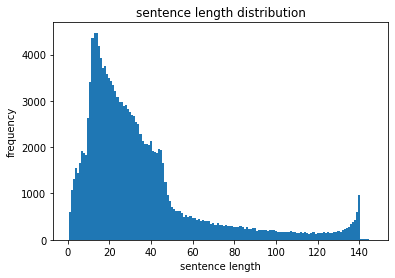

In [28]:
print("Data Size:", len(corpus))

for sen in corpus:
    length = len(sen)
    if min_len > length: 
        min_len = length
    if max_len < length: 
        max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(corpus))

# 문장 길이 분포 시각화
sentence_length = np.zeros((max_len), dtype=int)

for sen in corpus:
    sentence_length[len(sen) - 1] += 1

plt.bar(range(1, max_len + 1), sentence_length, width=1.0)
plt.title("sentence length distribution")
plt.xlabel("sentence length")
plt.ylabel("frequency")
plt.show()


### 1. 길이가 1인 문장 파악해보기
### 2. 유의미한 데이터 구간 파악해보기
### 3. 10부터 50까지 잘라보기

1. 길이가 1인 문장 파악해보기
- 역시 의미가 없거나 이모티콘이기에 노이즈로 판단

In [11]:
def check_sentence_with_length(corpus, length):
    count = 0
    
    for sen in corpus:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(corpus, 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳
ㅋ
네
ㅎ
ㅋ
굿
ㅇ
k
.
굿
굿
굳
ㅠ
?
1
ㅋ
굿
쒯
굿
굿
굳
♬
굿
토
ㅋ
ㅋ
굿
ㅋ
굿
O
똥
ㅎ
.
굿
ㅎ
짱
굳
굿
굿
짱
?
z
굿
짱
음
굳
ㅇ
헐
굳
굳
굿
굿
굿
삼
꽝
굿
굿
굿
굿
ㅎ
굳
굿
4
!
?
ㅎ
1
굳
.
ㅎ
풉
아
굿
똥
ㅅ
왜
ㄴ
굳
쉣
봐
z


In [15]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 4000을 초과하는 문장 길이를 추출합니다.
    if _sum > 4000:
        print("Outlier Index:", idx+1)

Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15


In [22]:
check_sentence_with_length(corpus, 12)

아햏햏 아햏햏 아햏햏.
단연 최고라고 할수있지
용가리 진짜짱짱맨이다ㅋ
나름 괜찮은 작품입니다
정말 실망 스러웟음..
무술인이 왜 총을드나?
너무너무 훈훈하네요^^
현실은 꿈, 꿈은 현실
답없네, 뭐하는건지..
엔딩이 넘 슬퍼요 :(
감동감동감동의 도가니탕
정말 최고의 영화...
진짜 짜증나는 영화..
상당히 재밌게 봤습니다
영상미가 역시 최고네요
감독ㅡㅡ다신영화찍지마라
이런 영화가 참 좋다.
정말 광해와 비슷한가?
더빙이 똥이야 ....
잠을 청할 수 있었다.
나오코 진짜 집중안된다
샬라샬라 나오다즁자쥬아
지루하다.. 지루해..
사과해요, 나한테!!!
소재가 굉장히 신선했다
솔직히 산만 하기만했다
OST가 좋은 영화!!
기적은 이미 일어났다.
답을 알려고 하지마라.
평점은 믿지마셈 재밌음
재미 드럽게 없다ㅋㅋㅋ
자식을 그렇게 때리냐?
감동적이였고 좋았습니다
울컥하는 사회현실 ㅠㅠ
등장인물들 모두 짱~~
막장드라마가 따로없구만
말 필요엄따~~~~진정
꿀잼 영화 추억이다ㅜㅜ
맞추자 ㅍ?차븟ㅇㄱ디시
순수하고 아름답다 :)
변태적 성욕 자기합리화
흠....나름 갠찬네요
걍 10점 이라길래..
실력이 필요없는 상황.
감동과 웃음을 한방에!
이거야 이거 ㅋㅋㅋㅋㅋ
성동일딸 시르다...참
평점알바들을 위해 1점
볼만합니다 강추!!ㅋㅋ
이거말고 겨울왕국을봐라
좋은니다..^.,^~~
2.3 (10자 제한)
아무도 안달았네..ㄷㄷ
엉성하고 어설프고...
그냥 보통으로 보았다.
너무 슬픈영화..울음ㅠ
으리는 개뿔 ㅡ,.ㅡ^
처음 본 에로 영화..
평점 조정을 위해...
그냥 쓰레기지 쓰레기~
쵝오네요 최고 대박영화
유전무죄 무전유죄!!!
의외의 꿀잼 이였습니다
어차피 우승은 송민호~
이 때부터가 쓰레기였지
완전 찝찝한 영화...
이상형이 바뀌었습니다.
역시 산드라블록 누님!
결국 엄마가 죽인거네?
그냥 그저 별시리...
추천할만한 경제영화였음
제대로 알아야할 역사임
일본판이더재미있음...
역시 재미있군요 >ㅁ<
아깝다 나의 1점도ㅡㅡ
마음이 따뜻해지는 영화
죽었다. 참 재미없다.

### 중복 제거
- 149995 -> 146182 로 3800여개 제거
- 평균길이 70 -> 35

Data Size: 146182
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


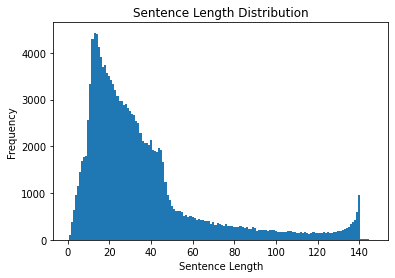

In [27]:
# 보이는건 중복이 없지만 그래도 중복 제거
# 중복된 문장을 제거
clean_corpus = list(set(corpus))
print("Data Size:", len(clean_corpus))

# 문장의 최단, 최장, 평균 길이를 계산하는 코드
min_len = 999
max_len = 0
sum_len = 0

for sen in clean_corpus:
    length = len(sen)
    if min_len > length: 
        min_len = length
    if max_len < length: 
        max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(clean_corpus))

# 문장 길이 분포 시각화
sentence_length = np.zeros((max_len), dtype=int)

for sen in clean_corpus:
    sentence_length[len(sen) - 1] += 1

plt.bar(range(1, max_len + 1), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

### 데이터 길이 제거
- 분포를 보면 10~50구간 사이 데이터가 가장 많이 분포되어 있는 것을 확인
- 데이터 양이 크기 때문에 과감하게 제거

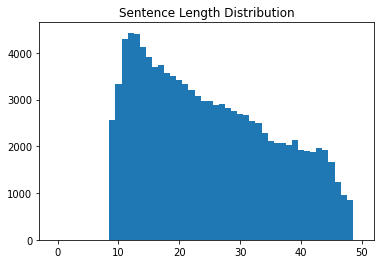

In [29]:
max_len = 50
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in clean_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### SentencePiece 학습
- SentencePieceProcessor 를 사용하여 모델 학습. Subword 기반 토크나이저 구축
- model_type은 `BPE(Byte Pair Encoding)` 과 `Unigram` 방식을 선택.
- `BPE(Byte Pair Encoding)` 는 자주 발생하는 바이트 쌍을 병합해 서브워드를 만듬(정교함, 데이터 길이를 길게 만듬)
- `Unigram` 는 서브워드를 데이터에서 자동으로 확률적 선택하여 어휘를 구성(일반적, 문맥파악)

In [30]:
import sentencepiece as spm

# corpus.txt 파일에 필터링된 문장들을 저장합니다.
with open('filtered_corpus.txt', 'w', encoding='utf-8') as f:
    for sentence in filtered_corpus:
        f.write(sentence + '\n')

# SentencePiece 모델 학습
spm.SentencePieceTrainer.train(input='filtered_corpus.txt', model_prefix='korean_spm', vocab_size=8000, model_type='unigram')

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: filtered_corpus.txt
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
 

## Step3. SentencePiece Tokenizer 함수 작성

In [31]:
import sentencepiece as spm
import tensorflow as tf

# 학습된 SentencePiece 모델 로드
sp = spm.SentencePieceProcessor()
sp.Load('korean_spm.model')

def sp_tokenize(corpus):
    # 문장들을 토큰화하여 ID 시퀀스로 변환
    tensor = [sp.EncodeAsIds(sentence) for sentence in corpus]
    
    # vocab 파일에서 단어 인덱스를 로드하여 word_index와 index_word 사전 생성
    with open('korean_spm.vocab', 'r', encoding='utf-8') as f:
        vocab = f.readlines()

    word_index = {line.split('\t')[0]: idx for idx, line in enumerate(vocab)}
    index_word = {idx: line.split('\t')[0] for idx, line in enumerate(vocab)}

    # 패딩 적용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

## Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

In [32]:
# 리뷰 문장과 레이블 추출
train_corpus = train_data['document'].tolist()
train_labels = train_data['label'].values

test_corpus = test_data['document'].tolist()
test_labels = test_data['label'].values

# SentencePiece를 사용한 토큰화
train_tensor, word_index, index_word = sp_tokenize(train_corpus)
test_tensor, _, _ = sp_tokenize(test_corpus)

### 모델 설계
- LSTM 기반 감성 분석 모델을 설계

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D

vocab_size = 8000  # SentencePiece에서 설정한 vocab_size와 동일

# 감성 분석을 위한 LSTM 모델
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(LSTM(128, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1024000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,155,713
Trainable params: 1,155,713
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [34]:
# 모델 학습
history = model.fit(train_tensor, train_labels, epochs=5, batch_size=64, validation_data=(test_tensor, test_labels))

Epoch 1/5
2344/2344 [==============================] - 47s 9ms/step - loss: 0.3663 - accuracy: 0.8339 - val_loss: 0.3235 - val_accuracy: 0.8575
Epoch 2/5
2344/2344 [==============================] - 21s 9ms/step - loss: 0.2839 - accuracy: 0.8779 - val_loss: 0.3127 - val_accuracy: 0.8638
Epoch 3/5
2344/2344 [==============================] - 21s 9ms/step - loss: 0.2480 - accuracy: 0.8951 - val_loss: 0.3211 - val_accuracy: 0.8633
Epoch 4/5
2344/2344 [==============================] - 21s 9ms/step - loss: 0.2127 - accuracy: 0.9123 - val_loss: 0.3417 - val_accuracy: 0.8613
Epoch 5/5
2344/2344 [==============================] - 21s 9ms/step - loss: 0.1739 - accuracy: 0.9295 - val_loss: 0.3664 - val_accuracy: 0.8555


### 모델 평가

In [35]:
# 모델 평가
test_loss, test_acc = model.evaluate(test_tensor, test_labels)
print(f"Test Accuracy: {test_acc}")

# 예측
predictions = model.predict(test_tensor)


1563/1563 [==============================] - 5s 3ms/step - loss: 0.3664 - accuracy: 0.8555
Test Accuracy: 0.8555113077163696


In [ ]:
# 모델 평가 (f1 score, precision, recall)
from sklearn.metrics import f1_score, precision_score, recall_score

# 예측값 얻기 (이진 분류이므로 0.5 기준으로 예측)
predictions = (model.predict(test_tensor) > 0.5).astype("int32")

# F1 Score 계산
f1 = f1_score(test_labels, predictions)

# Precision과 Recall 계산
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

### SentencePiece 학습(함수/모듈화)
- SentencePiece 모델을 학습하는 함수
    - 텍스트 파일로 모델 저장
    - SentencePiece 모델 학습
- SentencePiece Tokenizer 함수
- 전체 작업 실행
    - 네이버 영화리뷰 데이터 불러오기
    
    
> 실험: vocab size, model type 변경
- vocab size: 8000 -> 12000(과적합 위험이 있지만, 더 많은 정보를 학습하여 문맥 정보를 더 잘 반영)
- model type: unigram -> BPE(vocab 사이즈를 늘렸다면 등장 빈도가 높은 패턴을 효과적으로 인코딩)

In [37]:
import sentencepiece as spm
import tensorflow as tf
import pandas as pd

# SentencePiece 학습 함수
def train_sentencepiece(corpus, vocab_size=12000, model_prefix='korean_spm', model_type='bpe', output_file='filtered_corpus.txt'):

    # 텍스트 파일로 저장
    with open(output_file, 'w', encoding='utf-8') as f:
        for sentence in corpus:
            f.write(sentence + '\n')

    # SentencePiece 모델 학습
    spm.SentencePieceTrainer.train(input=output_file, model_prefix=model_prefix, vocab_size=vocab_size, model_type=model_type)
    print(f"모델 파일: {model_prefix}.model, {model_prefix}.vocab")

# SentencePiece Tokenizer 함수
def sp_tokenize(model_path, corpus):

    # 학습된 SentencePiece 모델 로드
    sp = spm.SentencePieceProcessor()
    sp.Load(f'{model_path}.model')

    # 문장들을 토큰화하여 ID 시퀀스로 변환
    tensor = [sp.EncodeAsIds(sentence) for sentence in corpus]
    
    # vocab 파일에서 단어 인덱스를 로드하여 word_index와 index_word 사전 생성
    with open(f'{model_path}.vocab', 'r', encoding='utf-8') as f:
        vocab = f.readlines()

    word_index = {line.split('\t')[0]: idx for idx, line in enumerate(vocab)}
    index_word = {idx: line.split('\t')[0] for idx, line in enumerate(vocab)}

    # 패딩 적용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

# 전체 작업을 실행하는 함수
def process_and_tokenize(train_data, test_data, vocab_size=12000, model_prefix='korean_spm', model_type='bpe'):

    # 리뷰 문장과 레이블 추출
    train_corpus = train_data['document'].tolist()
    train_labels = train_data['label'].values

    test_corpus = test_data['document'].tolist()
    test_labels = test_data['label'].values

    # SentencePiece 모델 학습
    train_sentencepiece(train_corpus, vocab_size, model_prefix, model_type)

    # SentencePiece를 사용한 토큰화
    train_tensor, word_index, index_word = sp_tokenize(model_prefix, train_corpus)
    test_tensor, _, _ = sp_tokenize(model_prefix, test_corpus)

    return train_tensor, test_tensor, word_index, index_word, train_labels, test_labels


# 실행 예시
if __name__ == "__main__":
    # 네이버 영화리뷰 데이터를 불러옵니다.
    train_data = pd.read_csv('ratings_train.txt', sep='\t')
    test_data = pd.read_csv('ratings_test.txt', sep='\t')

    # 결측값 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # SentencePiece 모델 학습 및 토큰화 과정 실행
    train_tensor, test_tensor, word_index, index_word, train_labels, test_labels = process_and_tokenize(train_data, test_data)

    # 출력 확인 (학습된 데이터 텐서, 단어 사전, 레이블)
    print(f"Train Tensor: {train_tensor.shape}, Test Tensor: {test_tensor.shape}")
    print(f"Word Index Size: {len(word_index)}, Index Word Size: {len(index_word)}")
    print(f"Train Labels: {train_labels[:5]}, Test Labels: {test_labels[:5]}")


모델 파일: korean_spm.model, korean_spm.vocab


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: filtered_corpus.txt
  input_format: 
  model_prefix: korean_spm
  model_type: BPE
  vocab_size: 12000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  es

Train Tensor: (149995, 117), Test Tensor: (49997, 113)
Word Index Size: 12000, Index Word Size: 12000
Train Labels: [0 1 0 0 1], Test Labels: [1 0 0 0 0]


### 모델 설계 후 학습 및 평가(함수화/모듈화)
- 1차) LSTM 레이어층 그대로 사용
- 2차) bidirectional, dropout, batchnomalization, 더 많은 Dense layer 추가

#### Bidirectional 이란?
LSTM은 시퀀스 데이터(한방향)를 읽음. 리뷰 텍스트같은 유형은 양방향으로 문맥을 파악하는 것이 중요.
앞에서 뒤로, 뒤에서 앞으로 데이터를 처리 하는 역할을 수행.

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Bidirectional, Dropout, BatchNormalization

vocab_size = 12000  # SentencePiece에서 설정한 vocab_size와 동일

# 감성 분석을 위한 LSTM 모델
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(Bidirectional(LSTM(128, return_sequences=True)))  # 양방향 LSTM 추가
model.add(Dropout(0.3))  # Dropout 추가
model.add(LSTM(64, return_sequences=True))  # 추가 LSTM 레이어
model.add(GlobalMaxPooling1D())  # Max Pooling
model.add(BatchNormalization())  # Batch Normalization 추가
model.add(Dense(64, activation='relu'))  # Dense 레이어 추가
model.add(Dense(1, activation='sigmoid'))  # 출력층

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1536000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          82176     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [46]:
# 모델 학습
history = model.fit(train_tensor, train_labels, epochs=10, batch_size=64, validation_data=(test_tensor, test_labels))

Epoch 1/10
2344/2344 [==============================] - 47s 20ms/step - loss: 0.1074 - accuracy: 0.9580 - val_loss: 0.5033 - val_accuracy: 0.8522
Epoch 2/10
2344/2344 [==============================] - 46s 20ms/step - loss: 0.0819 - accuracy: 0.9689 - val_loss: 0.5681 - val_accuracy: 0.8481
Epoch 3/10
2344/2344 [==============================] - 46s 20ms/step - loss: 0.0611 - accuracy: 0.9769 - val_loss: 0.6696 - val_accuracy: 0.8482
Epoch 4/10
2344/2344 [==============================] - 46s 20ms/step - loss: 0.0497 - accuracy: 0.9814 - val_loss: 0.7072 - val_accuracy: 0.8380
Epoch 5/10
2344/2344 [==============================] - 46s 20ms/step - loss: 0.0420 - accuracy: 0.9846 - val_loss: 0.7774 - val_accuracy: 0.8419
Epoch 6/10
2344/2344 [==============================] - 46s 20ms/step - loss: 0.0369 - accuracy: 0.9866 - val_loss: 0.8167 - val_accuracy: 0.8418
Epoch 7/10
2344/2344 [==============================] - 46s 20ms/step - loss: 0.0322 - accuracy: 0.9881 - val_loss: 0.8249 -

In [61]:
# 모델 평가
test_loss, test_acc = model.evaluate(test_tensor, test_labels)
print(f"Test Accuracy: {test_acc}")

# 예측
predictions = model.predict(test_tensor)

1563/1563 [==============================] - 10s 7ms/step - loss: 0.7490 - accuracy: 0.8266
Test Accuracy: 0.8266295790672302


### 실험 결과
vocab size도 바꿔봤고, model type도 바꿔봤고, layer 층도 추가해봤다.
하지만 성능이 올라가는 변화는 없었고 미미했다.

> 가장 좋을 것 같은 파라미터로 설정
- vocab size는 defalt 값 그대로 8000 고정.(많거나 적어도 과소/과대적합 문제)
- model type은 'unigram' 설정.(bpe는 데이터가 많으면 성능이 떨어짐)
- layer 층은 추가한 그대로 진행.(여러개 쌓을 수록 좋다. dropout은 한번)

In [64]:
# SentencePiece 학습 함수
def train_sentencepiece(corpus, vocab_size=8000, model_prefix='korean_spm', model_type='unigram', output_file='filtered_corpus.txt'):

    # 텍스트 파일로 저장
    with open(output_file, 'w', encoding='utf-8') as f:
        for sentence in corpus:
            f.write(sentence + '\n')

    # SentencePiece 모델 학습
    spm.SentencePieceTrainer.train(input=output_file, model_prefix=model_prefix, vocab_size=vocab_size, model_type=model_type)
    print(f"모델 파일: {model_prefix}.model, {model_prefix}.vocab")

# SentencePiece Tokenizer 함수
def sp_tokenize(model_path, corpus):

    # 학습된 SentencePiece 모델 로드
    sp = spm.SentencePieceProcessor()
    sp.Load(f'{model_path}.model')

    # 문장들을 토큰화하여 ID 시퀀스로 변환
    tensor = [sp.EncodeAsIds(sentence) for sentence in corpus]
    
    # vocab 파일에서 단어 인덱스를 로드하여 word_index와 index_word 사전 생성
    with open(f'{model_path}.vocab', 'r', encoding='utf-8') as f:
        vocab = f.readlines()

    word_index = {line.split('\t')[0]: idx for idx, line in enumerate(vocab)}
    index_word = {idx: line.split('\t')[0] for idx, line in enumerate(vocab)}

    # 패딩 적용
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

# 전체 작업을 실행하는 함수
def process_and_tokenize(train_data, test_data, vocab_size=8000, model_prefix='korean_spm', model_type='bpe'):

    # 리뷰 문장과 레이블 추출
    train_corpus = train_data['document'].tolist()
    train_labels = train_data['label'].values

    test_corpus = test_data['document'].tolist()
    test_labels = test_data['label'].values

    # SentencePiece 모델 학습
    train_sentencepiece(train_corpus, vocab_size, model_prefix, model_type)

    # SentencePiece를 사용한 토큰화
    train_tensor, word_index, index_word = sp_tokenize(model_prefix, train_corpus)
    test_tensor, _, _ = sp_tokenize(model_prefix, test_corpus)

    return train_tensor, test_tensor, word_index, index_word, train_labels, test_labels


# 실행 예시
if __name__ == "__main__":
    # 네이버 영화리뷰 데이터를 불러옵니다.
    train_data = pd.read_csv('ratings_train.txt', sep='\t')
    test_data = pd.read_csv('ratings_test.txt', sep='\t')

    # 결측값 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # SentencePiece 모델 학습 및 토큰화 과정 실행
    train_tensor, test_tensor, word_index, index_word, train_labels, test_labels = process_and_tokenize(train_data, test_data)


모델 파일: korean_spm.model, korean_spm.vocab


In [65]:
# 모델 설계
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Bidirectional, Dropout, BatchNormalization

vocab_size = 8000  # SentencePiece에서 설정한 vocab_size와 동일

# 감성 분석을 위한 LSTM 모델
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128))
model.add(Bidirectional(LSTM(128, return_sequences=True)))  # 양방향 LSTM 추가
model.add(Dropout(0.3))  # Dropout 추가
model.add(LSTM(64, return_sequences=True))  # 추가 LSTM 레이어
model.add(GlobalMaxPooling1D())  # Max Pooling
model.add(BatchNormalization())  # Batch Normalization 추가
model.add(Dense(64, activation='relu'))  # Dense 레이어 추가
model.add(Dense(1, activation='sigmoid'))  # 출력층

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 128)         1024000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 256)         263168    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 64)          82176     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [67]:
# 모델 학습
history = model.fit(train_tensor, train_labels, epochs=5, batch_size=64, validation_data=(test_tensor, test_labels))

Epoch 1/5
2344/2344 [==============================] - 50s 21ms/step - loss: 0.0636 - accuracy: 0.9765 - val_loss: 0.7019 - val_accuracy: 0.8448
Epoch 2/5
2344/2344 [==============================] - 49s 21ms/step - loss: 0.0504 - accuracy: 0.9818 - val_loss: 0.7405 - val_accuracy: 0.8426
Epoch 3/5
2344/2344 [==============================] - 49s 21ms/step - loss: 0.0458 - accuracy: 0.9832 - val_loss: 0.7494 - val_accuracy: 0.8416
Epoch 4/5
2344/2344 [==============================] - 49s 21ms/step - loss: 0.0397 - accuracy: 0.9855 - val_loss: 0.8036 - val_accuracy: 0.8409
Epoch 5/5
2344/2344 [==============================] - 49s 21ms/step - loss: 0.0363 - accuracy: 0.9866 - val_loss: 0.8576 - val_accuracy: 0.8427


In [68]:
# 모델 평가 (f1 score, precision, recall)
from sklearn.metrics import f1_score, precision_score, recall_score

# 예측값 얻기 (이진 분류이므로 0.5 기준으로 예측)
predictions = (model.predict(test_tensor) > 0.5).astype("int32")

# F1 Score 계산
f1 = f1_score(test_labels, predictions)

# Precision과 Recall 계산
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.842499349336323
Precision: 0.8491807248365486
Recall: 0.8359222915259624


### koNLPy 형태소 분석기와 비교하기

In [54]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [55]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 한국어 형태소 분석기 Mecab 사용
tokenizer = Mecab()

# 불용어 리스트
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

def load_data(train_data, test_data, num_words=10000, maxlen=30):
    # 1. NaN 결측치 제거
    train_data = train_data.dropna(how='any').copy()  # copy()로 복사본 생성
    test_data = test_data.dropna(how='any').copy()

    # 2. 중복 제거
    train_data = train_data.drop_duplicates(subset=['document']).copy()
    test_data = test_data.drop_duplicates(subset=['document']).copy()

    # 3. 한국어 토크나이저로 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        tokenized_sentence = tokenizer.morphs(sentence)  # 토큰화
        tokenized_sentence = [word for word in tokenized_sentence if word not in stopwords]  # 불용어 제거
        X_train.append(tokenized_sentence)
    
    X_test = []
    for sentence in test_data['document']:
        tokenized_sentence = tokenizer.morphs(sentence)  # 토큰화
        tokenized_sentence = [word for word in tokenized_sentence if word not in stopwords]  # 불용어 제거
        X_test.append(tokenized_sentence)

    # 4. 사전 word_to_index 구성
    all_tokens = [word for sentence in X_train for word in sentence]
    vocab = Counter(all_tokens)
    vocab = vocab.most_common(num_words - 4)  # 상위 num_words-4개의 단어를 선택

    word_to_index = {word: idx + 4 for idx, (word, _) in enumerate(vocab)}
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2
    word_to_index["<UNUSED>"] = 3

    # 5. 텍스트 데이터를 사전 인덱스로 변환
    def text_to_index(sentences, word_to_index):
        results = []
        for sentence in sentences:
            temp_result = []
            for word in sentence:
                if word in word_to_index:
                    temp_result.append(word_to_index[word])
                else:
                    temp_result.append(word_to_index["<UNK>"])
            results.append(temp_result)
        return results

    X_train = text_to_index(X_train, word_to_index)
    X_test = text_to_index(X_test, word_to_index)

    # 6. 패딩 추가: 문장의 길이를 고정된 길이로 맞추기
    X_train = pad_sequences(X_train, maxlen=maxlen, padding='pre')
    X_test = pad_sequences(X_test, maxlen=maxlen, padding='pre')

    # 7. 라벨 y_train, y_test 추출 (라벨 데이터)
    y_train = np.array(train_data['label'])
    y_test = np.array(test_data['label'])

    return np.array(X_train), y_train, np.array(X_test), y_test, word_to_index

# 데이터 전처리 수행
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [70]:
from konlpy.tag import Okt

okt = Okt()

def okt_tokenize(corpus):
    tokenized_corpus = []
    for sentence in corpus:
        tokens = [word for word, _ in okt.pos(sentence)]
        tokenized_corpus.append(tokens)
    
    tensor = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False)
    tensor.fit_on_texts(tokenized_corpus)
    tensor = tensor.texts_to_sequences(tokenized_corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor

# KoNLPy를 이용한 토큰화
train_tensor_okt = okt_tokenize(train_corpus)
test_tensor_okt = okt_tokenize(test_corpus)

# 동일한 모델을 이용하여 학습
model.fit(train_tensor_okt, train_labels, epochs=5, batch_size=64, validation_data=(test_tensor_okt, test_labels))


Epoch 1/5
2344/2344 [==============================] - 42s 17ms/step - loss: 0.4409 - accuracy: 0.7840 - val_loss: 0.9739 - val_accuracy: 0.5132
Epoch 2/5
2344/2344 [==============================] - 39s 17ms/step - loss: 0.3153 - accuracy: 0.8608 - val_loss: 1.0502 - val_accuracy: 0.5168
Epoch 3/5
2344/2344 [==============================] - 40s 17ms/step - loss: 0.2824 - accuracy: 0.8763 - val_loss: 1.0185 - val_accuracy: 0.5171
Epoch 4/5
2344/2344 [==============================] - 39s 17ms/step - loss: 0.2496 - accuracy: 0.8913 - val_loss: 1.1242 - val_accuracy: 0.5227
Epoch 5/5
2344/2344 [==============================] - 39s 17ms/step - loss: 0.2108 - accuracy: 0.9085 - val_loss: 1.3234 - val_accuracy: 0.5236


#### KoNLPy 형태소 분석기와 비슷하니. accuracy는 잘 나왔어도 val accuracy는 SentencePiece 모델이 더 잘 나왔다.
- SentencePiece: 0.85, KoNLPy: 0.52

## 회고
오늘 NLP GoingDeeper 프로젝트를 진행해봤다. Google의 SentencePiece 모델을 구현해보고 적용해봤는데 생각보다 재밌었다. 전에도 네이버 영화리뷰 데이터로 Word2vec 을 사용해서 성능 개선해보고 그랬던 것 같은데, 그것과는 결이 같으면서 다른 모델을 사용해 성능을 분석하였고, 무엇보다 데이터의 특성에 따라 모델 파라미터 적용 여부가 극명하게 나눠질 수도 있다는게 흥미로웠다. 예를들어 vocab size를 늘린다거나 드랍아웃을 추가한다거나, 그 조정이 별거 아닐 수 있어도 영향을 많이 끼칠 수도, 적게 끼질 수도 있으니 좋은 모델이라고 다 좋은 것은 아니며 실험을 해보며 기록하고 측정하는 것이 중요하다고 느꼈다.